<h1 align="center"> Titanic Kaggle com AutoML </h1>
<p>Na minha ultima tentativa de participar do desafio do titanic do Kaggle eu sai um pouco desanimado com minha colocação, um pessimo 8080º lugar com 0,76 de score.</p>
<p>Após dar uma olhada no que eu fiz encontre varias coisas que eu podia melhorar, para começar quero resolver 2 problemas.<p>
<h2 align="center">overfitting</h2>
<img src="overfitting.jpg"  width="400"/>
<p>Meus algoritmos de Random Forest e Decision Tree tiveram pontuação muito alta, mais de 98%, e meu desempenho com o dataset de teste não foi tão bom, isso me faz pensar que estamos usando muitas variais que provavelmente estão deixando o algoritmo "acostumado" com o nosso dataset, vamos tentar amenizar esse problema removendo algumas colunas menos importantes do nosso dataset.<p>
<h2 align="center">Escolha Algoritmo Correto / Tunning</h2>
<p>Como o algoritmo de Random Forest tinha obtido a melhor pontuação nos testes envie a resposta obtidas com ele para o kaggle, não tenho certeza se foi a melhor escolha, e também não alterei nenhum parâmetro do algoritmo.<p>
<p>Para tentar resolver esse problema vou usar a ferramenta de AutoML da plataforma h2o.<p>


In [1]:
#importando Pandas S2
import pandas as pd
#importa matplotlib (graficos)
import matplotlib.pyplot as plt
#importando numpy
import numpy as np
#importando  random forest
from sklearn.ensemble import RandomForestClassifier
#importa selecionador de recursos com base na importancia
from sklearn.feature_selection import SelectFromModel
#importando H2O
import h2o
from h2o.automl import H2OAutoML

In [2]:
#importa dataset treino
df = pd.read_csv("data/df.csv")
#importa dataset teste
teste = pd.read_csv("data/teste.csv")
#mostra primeiras linhas dataset treino
df.head()

,Unnamed: 0,PassengerId,Survived,Sex,Age,Fare,Titulo_Master,Titulo_Miss,Titulo_Mr,Titulo_Mrs,Titulo_Nobre,Titulo_Oficial,Emb_C,Emb_Q,Emb_S,Classe_1,Classe_2,Classe_3,Tamanho_Familia,Sozinho
0,0,1,0,1,22.0,7.2500,0,0,1,0,0,0,0,0,1,0,0,1,2,0
1,1,2,1,0,38.0,71.2833,0,0,0,1,0,0,1,0,0,1,0,0,2,0
2,2,3,1,0,26.0,7.9250,0,1,0,0,0,0,0,0,1,0,0,1,1,1
3,3,4,1,0,35.0,53.1000,0,0,0,1,0,0,0,0,1,1,0,0,2,0
4,4,5,0,1,35.0,8.0500,0,0,1,0,0,0,0,0,1,0,0,1,1,1


<h2>Escolhendo colunas</h2>
<p>Vamos escolher quais colunas tem mais importancia e manter elas.</p>

In [3]:
#definindo dataframe teste
X_train = df.drop(['Survived', 'PassengerId', 'Unnamed: 0'], axis=1)
Y_train = df['Survived']
X_test = teste.drop(['PassengerId', 'Unnamed: 0'], axis=1)
X_train.shape, Y_train.shape, X_test.shape

((891, 17), (891,), (418, 17))

In [4]:
#Treina algoritmo de random forest
rfc = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rfc = rfc.fit(X_train, Y_train)

In [5]:
#salva importancia de cada coluna em um dataframe
colunas = pd.DataFrame()
colunas['colunas'] = X_train.columns
colunas['importancia'] = rfc.feature_importances_
colunas.sort_values(by=['importancia'], ascending=True, inplace=True)
colunas.set_index('colunas', inplace=True)

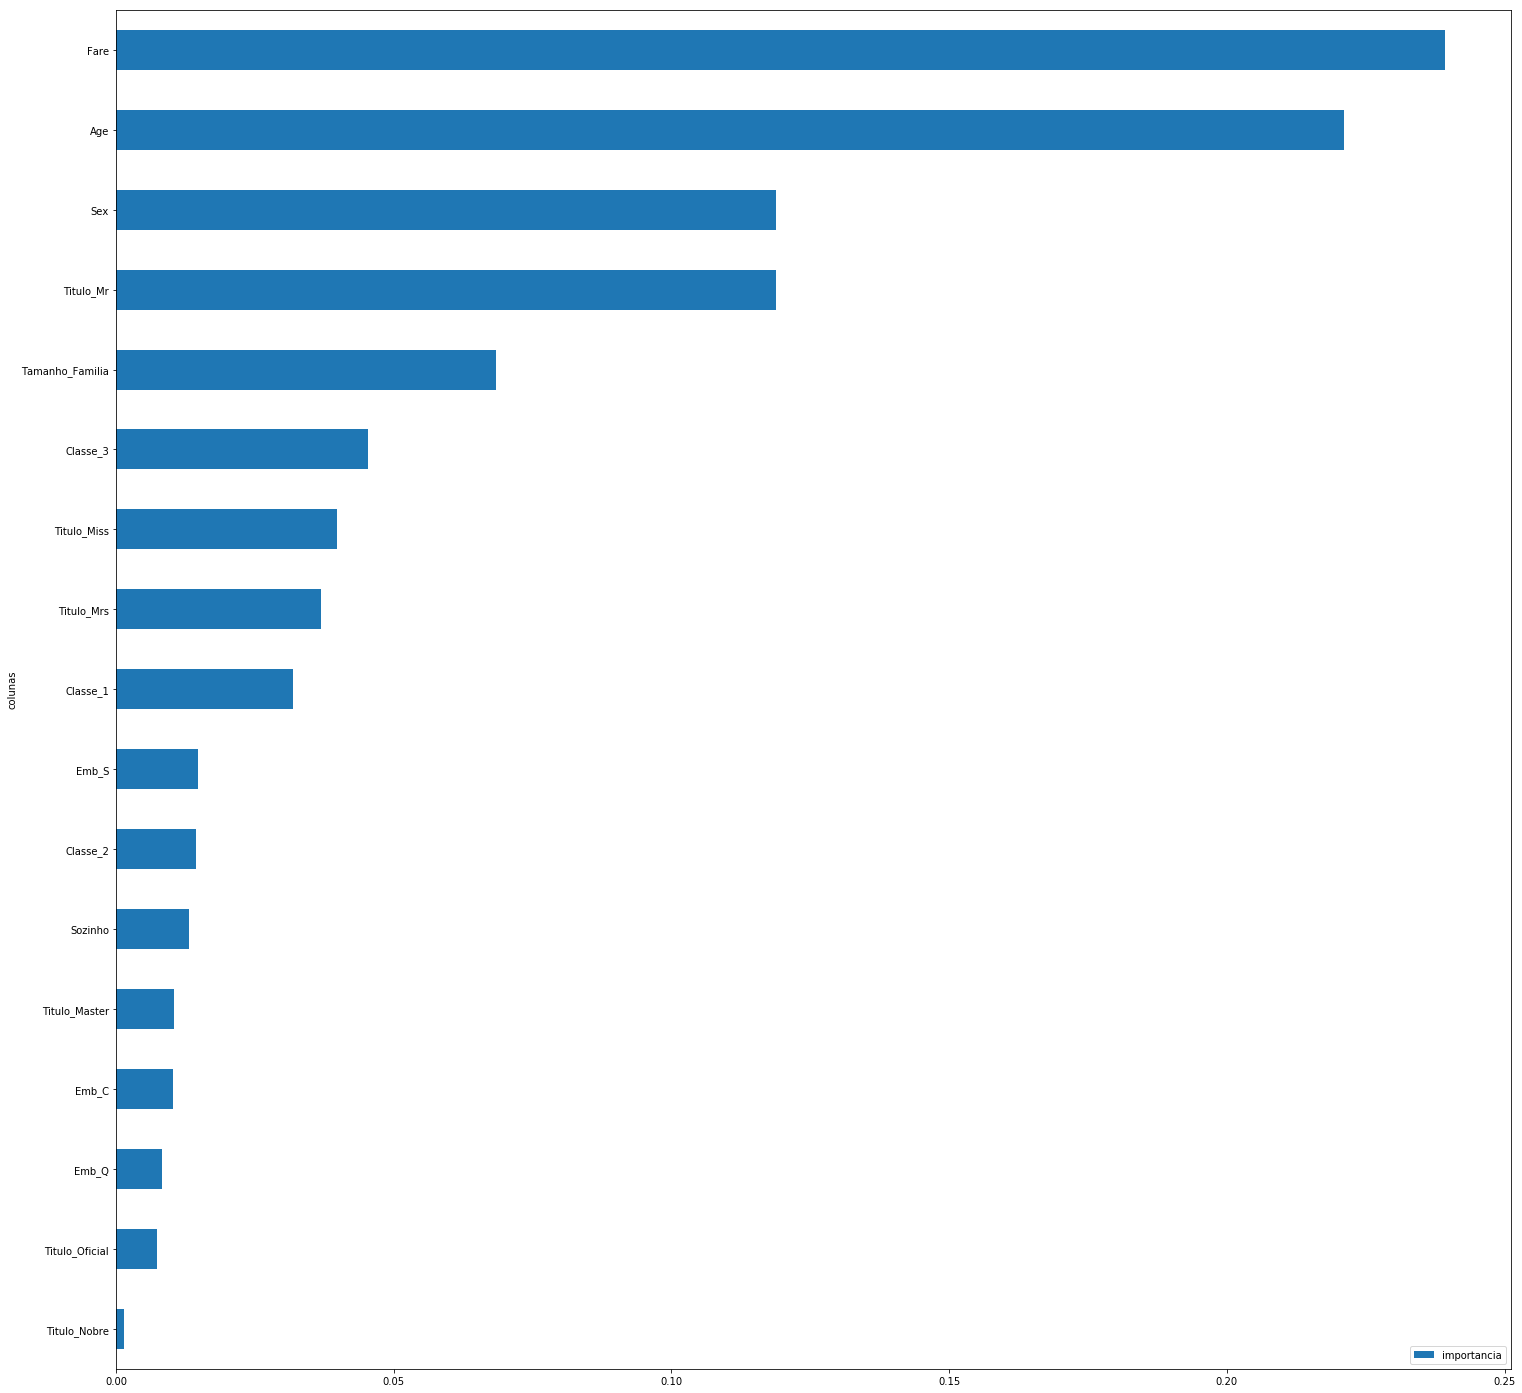

In [6]:
#monta grafico com a importancia de cada coluna
colunas.plot(kind='barh', figsize=(25, 25))

In [15]:
#Removendo colunas com menor importancia
modelo = SelectFromModel(rfc, threshold=0.01, prefit=True)
train_reduzido = modelo.transform(X_train)
print(train_reduzido.shape)

teste_reduzido = modelo.transform(X_test)
print(test_reduzido.shape)

(891, 14)
(418, 14)


<p>Com isso removemos as 3 colunas com menor importancia do nosso dataset, agora vamos testar a ferramenta de AutoML</p>

<h2>AutoML</h2>
Para rodar a ferramenta de AutoML precisamos iniciar um cluster, e também precisamos importar os dados para ele, infelizmente não achei uma maneira de usar um dataset do Pandas de maneira direta para rodar os aloritmos.

In [22]:
#inicia cluster 
#nthreads define o numero de núcleos usados 
#max_men_size define o maixmo de meoria usada 
h2o.init(nthreads = -1, max_mem_size= 6)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from c:\users\samuel\appdata\local\programs\python\python36\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Samuel\AppData\Local\Temp\tmpeyiq62td
  JVM stdout: C:\Users\Samuel\AppData\Local\Temp\tmpeyiq62td\h2o_Samuel_started_from_python.out
  JVM stderr: C:\Users\Samuel\AppData\Local\Temp\tmpeyiq62td\h2o_Samuel_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Sao_Paulo
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,1 month and 23 days
H2O cluster name:,H2O_from_python_Samuel_oi9oiy
H2O cluster total nodes:,1
H2O cluster free memory:,5.333 Gb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"accepting new members, healthy"


In [23]:
#transformando array em dataframe
treino_reduzido = pd.DataFrame(train_reduzido)
teste_reduzido = pd.DataFrame(teste_reduzido)
#exportando dataframes
treino_reduzido.to_csv('treino')
teste_reduzido.to_csv('teste')
Y_train.to_csv('resultado_treino')

c:\users\samuel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys


In [153]:
#importa dados para h2o e faz parse
treino_h2o = h2o.import_file('treino')
resultado_treino = h2o.import_file('resultado_treino')
teste_h2o = h2o.import_file('teste')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [80]:
#remove coluna index
treino_h2o = treino_h2o.drop('C1')
resultado_treino = resultado_treino.drop('C1')
test = teste_h2o.drop('C1')

In [89]:
resultado_treino = resultado_treino.set_names(['y'])
train = treino_h2o.cbind(resultado_treino)

In [110]:
x = train.columns
y = "y"
x.remove('y')

train[y] = train[y].asfactor()

In [111]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [172]:
preds = aml.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [159]:
resultado_final = preds['predict']

In [207]:
df_resultado = resultado_final.as_data_frame()

In [208]:
df_resultado.columns = ['Survived']
df_resultado['PassengerId'] = df_resultado.index + 891

In [212]:
df_resultado =  df_resultado[['PassengerId', 'Survived']]
df_resultado = df_resultado.set_index('PassengerId')

In [1]:
df_resultado.to_csv('resultado_final')

NameError: name 'df_resultado' is not defined

<h2>Resultado</h2>
<p>Após exportar o dataset final com as predições percebi que ele tinha uma linha a mais, removi essa linha e enviei ele para kaggle</p>
<p>Tive uma melhora na minha pontuação, porem muito baixa o que me leva a pensar que o problema para não alcançar uma pontuação maior foi os dados que eu escolhi usar</p>
<p>Irei fazer outra tentativa mudando as seguintes coisas.</p>
<ul>
    <li>POO - para facilitar leitura e aplicação das alterações</li>
    <li>Utilização dos dados de ticket dos passageiros</li>
    <li>Utilização dos dados de cabine dos passageitos</li>
    <li>Preencher as idades usando idade média de cada titulo</li>
</ul>
<p>Ainda não tenho certeza se utilizarei novamente a ferramenta de AutoML, o tempo que ela gasta para treinar/tunnar os algoritmos é relativamente alto. Escolher bem os dados que vc utiliza para sua análise é mais importante do que ter um algoritmo super "tunado", não adianta tentar resolver um problema que começou com a seleção dos dados com um algoritmo diferente<p>